In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

Загрузка датасета

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.sample(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
350,899187,B,11.66,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.01162,...,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825,NaN
259,88725602,M,15.53,33.56,103.70,744.9,0.10630,0.16390,0.175100,0.08399,...,49.54,126.30,1035.0,0.18830,0.55640,0.57030,0.20140,0.3512,0.12040,NaN
115,864685,B,11.93,21.53,76.53,438.6,0.09768,0.07849,0.033280,0.02008,...,26.15,87.54,583.0,0.15000,0.23990,0.15030,0.07247,0.2438,0.08541,NaN
60,858970,B,10.17,14.88,64.55,311.9,0.11340,0.08061,0.010840,0.01290,...,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,NaN
275,8911164,B,11.89,17.36,76.20,435.6,0.12250,0.07210,0.059290,0.07404,...,18.99,79.46,472.4,0.13590,0.08368,0.07153,0.08946,0.2220,0.06033,NaN


## EDA

#### Удаление пропусков и неинформитивных признаков

In [4]:
data.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [5]:
data.drop(columns=['id','Unnamed: 32'],inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### Кодировка признака 'diagnosis'

In [7]:
data['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [8]:
data['diagnosis'] = data['diagnosis'].replace({'M': 1.0, 'B': 0.0})

#### Меры центральной тенденции

In [9]:
central_tendency = pd.DataFrame({'Min': data.min(), 'Max': data.max(),
                                 'Mean': data.mean(), 'Median': data.median(),
                                 'Moda': data.mode().iloc[0], 'STD': data.std(),
                                 'Q 0.25': data.quantile(0.25), 'Q 0.50': data.quantile(0.50),
                                 'Q 0.75': data.quantile(0.75), 'Q 0.90': data.quantile(0.90),
                                 'Q 0.95': data.quantile(0.95), 'Q 0.99': data.quantile(0.99),
                                 'Q 0.95 / Q 0.99': data.quantile(0.95) / data.quantile(0.99)})
central_tendency[1:]

,Min,Max,Mean,Median,Moda,STD,Q 0.25,Q 0.50,Q 0.75,Q 0.90,Q 0.95,Q 0.99,Q 0.95 / Q 0.99
radius_mean,6.981000,28.11000,14.127292,13.370000,12.340000,3.524049,11.700000,13.370000,15.780000,19.530000,20.576000,24.371600,0.844261
texture_mean,9.710000,39.28000,19.289649,18.840000,14.930000,4.301036,16.170000,18.840000,21.800000,24.992000,27.150000,30.652000,0.885750
perimeter_mean,43.790000,188.50000,91.969033,86.240000,82.610000,24.298981,75.170000,86.240000,104.100000,129.100000,135.820000,165.724000,0.819555
area_mean,143.500000,2501.00000,654.889104,551.100000,512.200000,351.914129,420.300000,551.100000,782.700000,1177.400000,1309.800000,1786.600000,0.733124
smoothness_mean,0.052630,0.16340,0.096360,0.095870,0.100700,0.014064,0.086370,0.095870,0.105300,0.114820,0.118780,0.132888,0.893835
compactness_mean,0.019380,0.34540,0.104341,0.092630,0.114700,0.052813,0.064920,0.092630,0.130400,0.175460,0.208700,0.277192,0.752908
concavity_mean,0.000000,0.42680,0.088799,0.061540,0.000000,0.079720,0.029560,0.061540,0.130700,0.203040,0.243020,0.351688,0.691010
concave points_mean,0.000000,0.20120,0.048919,0.033500,0.000000,0.038803,0.020310,0.033500,0.074000,0.100420,0.125740,0.164208,0.765736
symmetry_mean,0.106000,0.30400,0.181162,0.179200,0.160100,0.027414,0.161900,0.179200,0.195700,0.214940,0.230720,0.259564,0.888875
fractal_dimension_mean,0.049960,0.09744,0.062798,0.061540,0.056670,0.007060,0.057700,0.061540,0.066120,0.072266,0.076090,0.085438,0.890591


#### Распределение признаков

In [10]:
diagnosis_colors = ['#68b377', '#d66970']

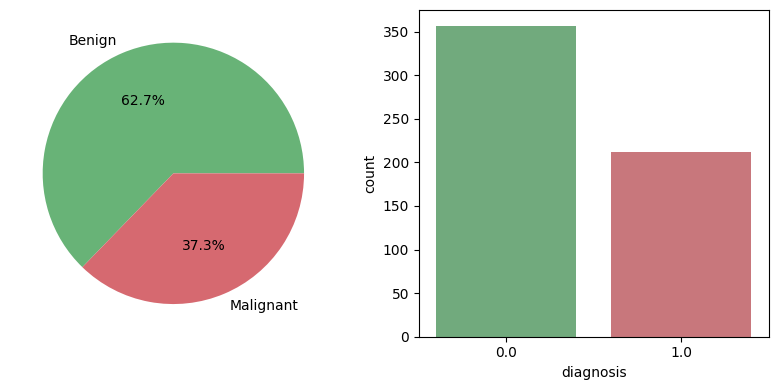

In [11]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.pie(data['diagnosis'].value_counts(), autopct='%1.1f%%', labels=['Benign', 'Malignant'], colors=diagnosis_colors)

plt.subplot(1, 2, 2)
sns.countplot(data=data, x='diagnosis', palette=diagnosis_colors)

plt.tight_layout()
plt.show()

In [12]:
y_column = data.columns[0]
x_columns = data.drop(['diagnosis'], axis=1).columns

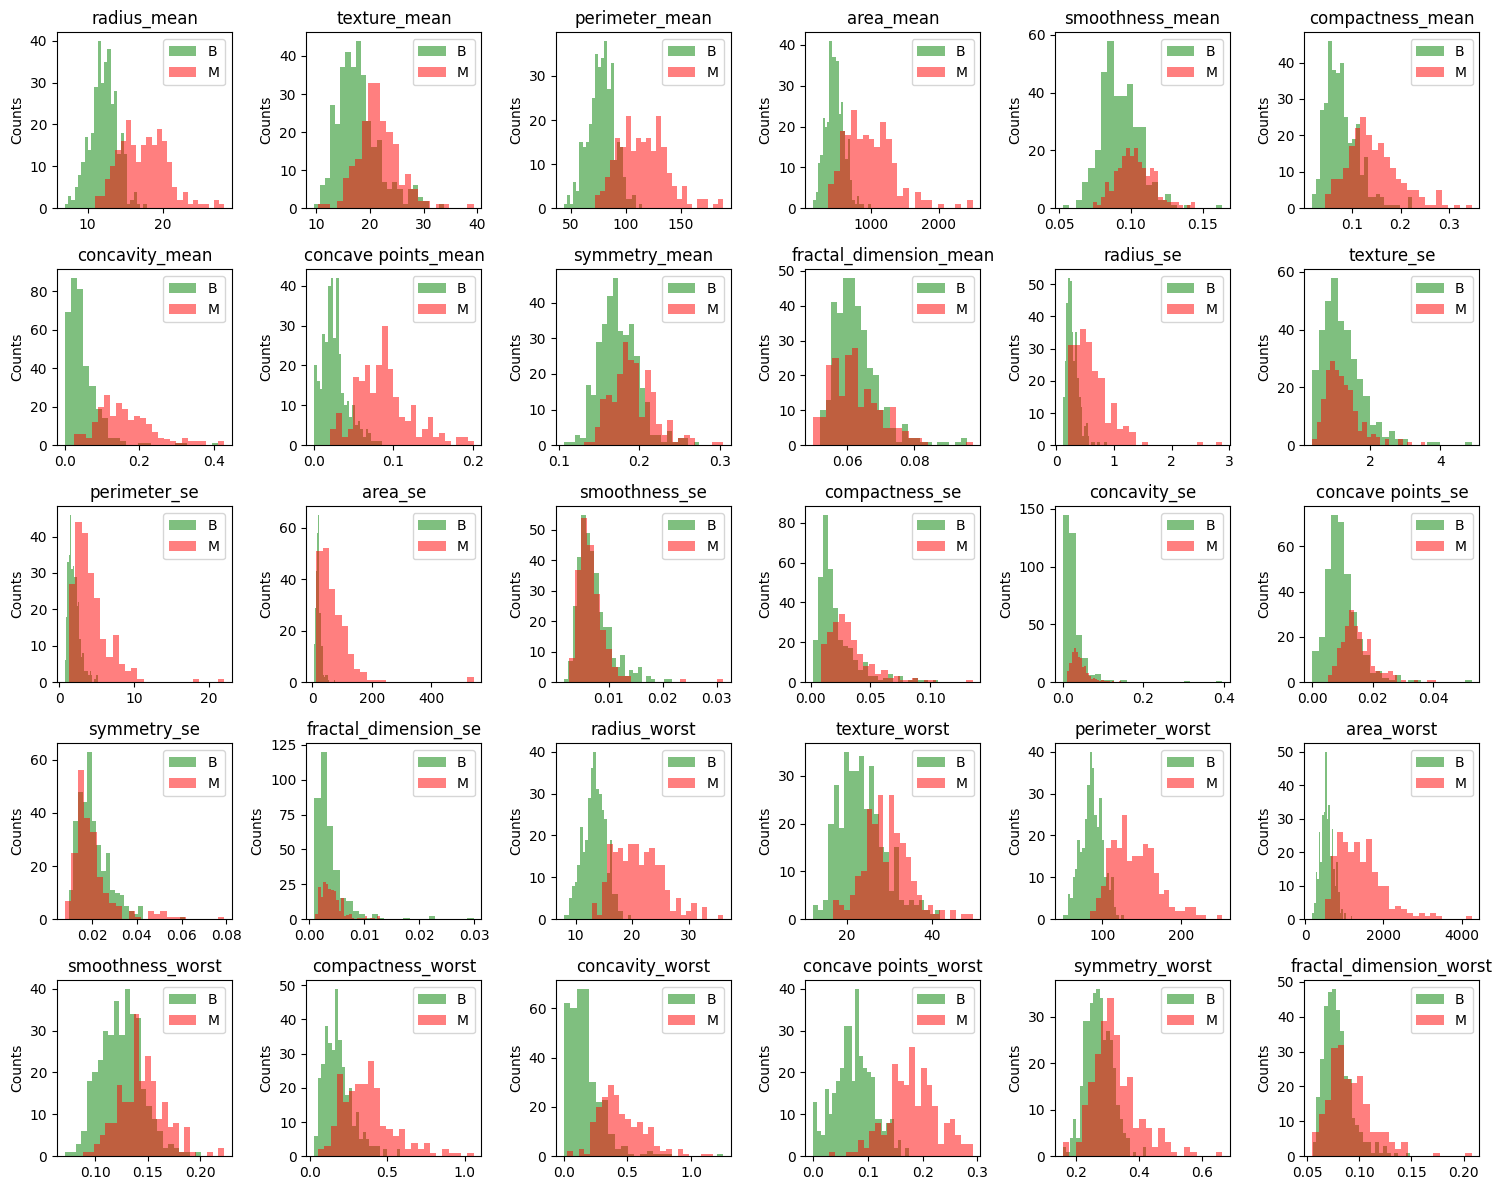

In [13]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(data.columns[1:]):

    plt.subplot(5, 6, i+1).set_title(col)

    x_col = data[x_columns[i]].values
    y_col = data[y_column].values

    plt.hist(x_col[y_col == 0.0], label='B', color='green', alpha=0.5,  bins=25)
    plt.hist(x_col[y_col == 1.0], label='M', color='red', alpha=0.5,  bins=25)

    plt.ylabel('Counts')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

#### Матрица корреляций

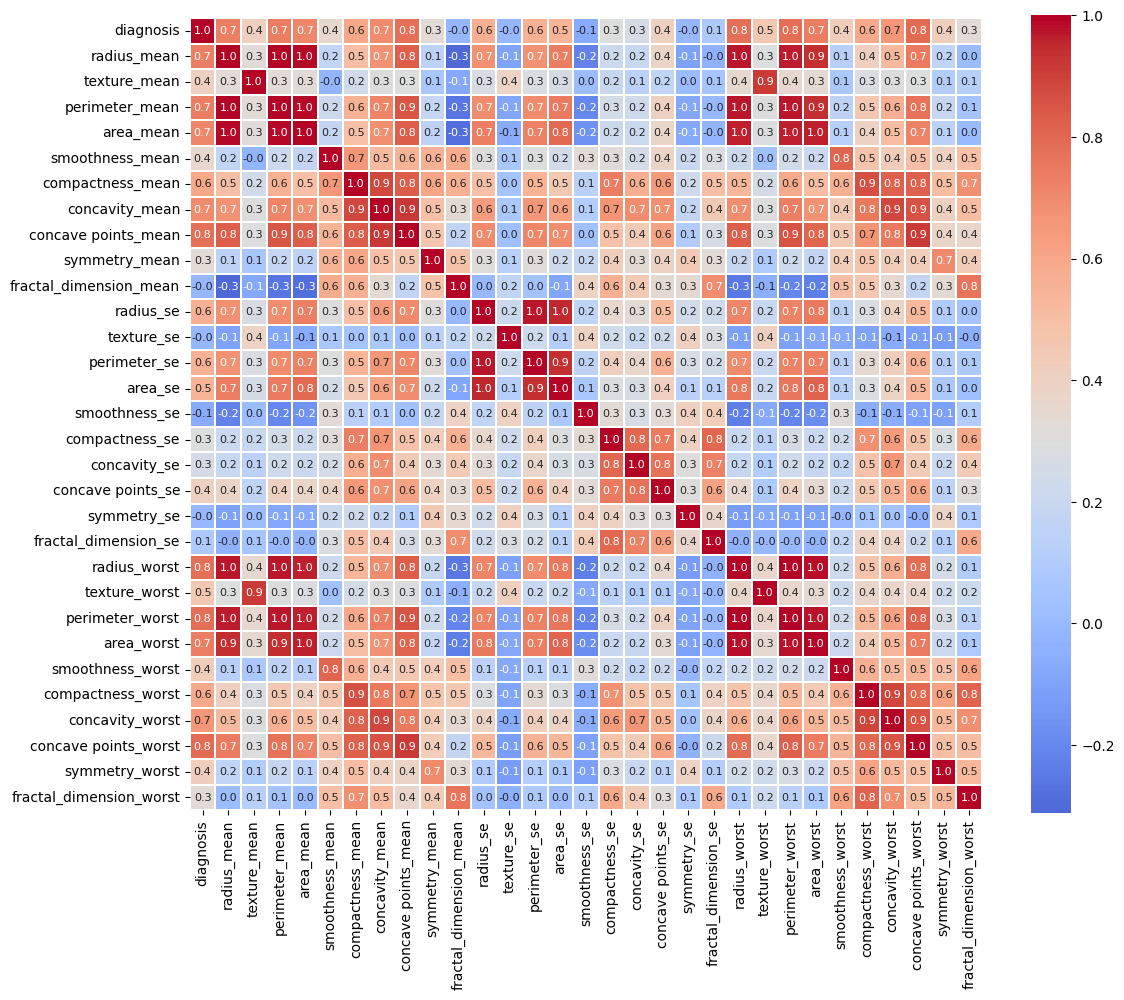

In [14]:
plt.figure(figsize=[12, 10])
sns.heatmap(data.corr(), annot=True , fmt = '.1f', annot_kws={"fontsize": 8}, linewidths=0.25, center= 0.3, cmap= 'coolwarm', square=True)

plt.tight_layout()
plt.show()

In [15]:
data.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


Коэффициент корреляции свыше 0.7 у усредненных признаков

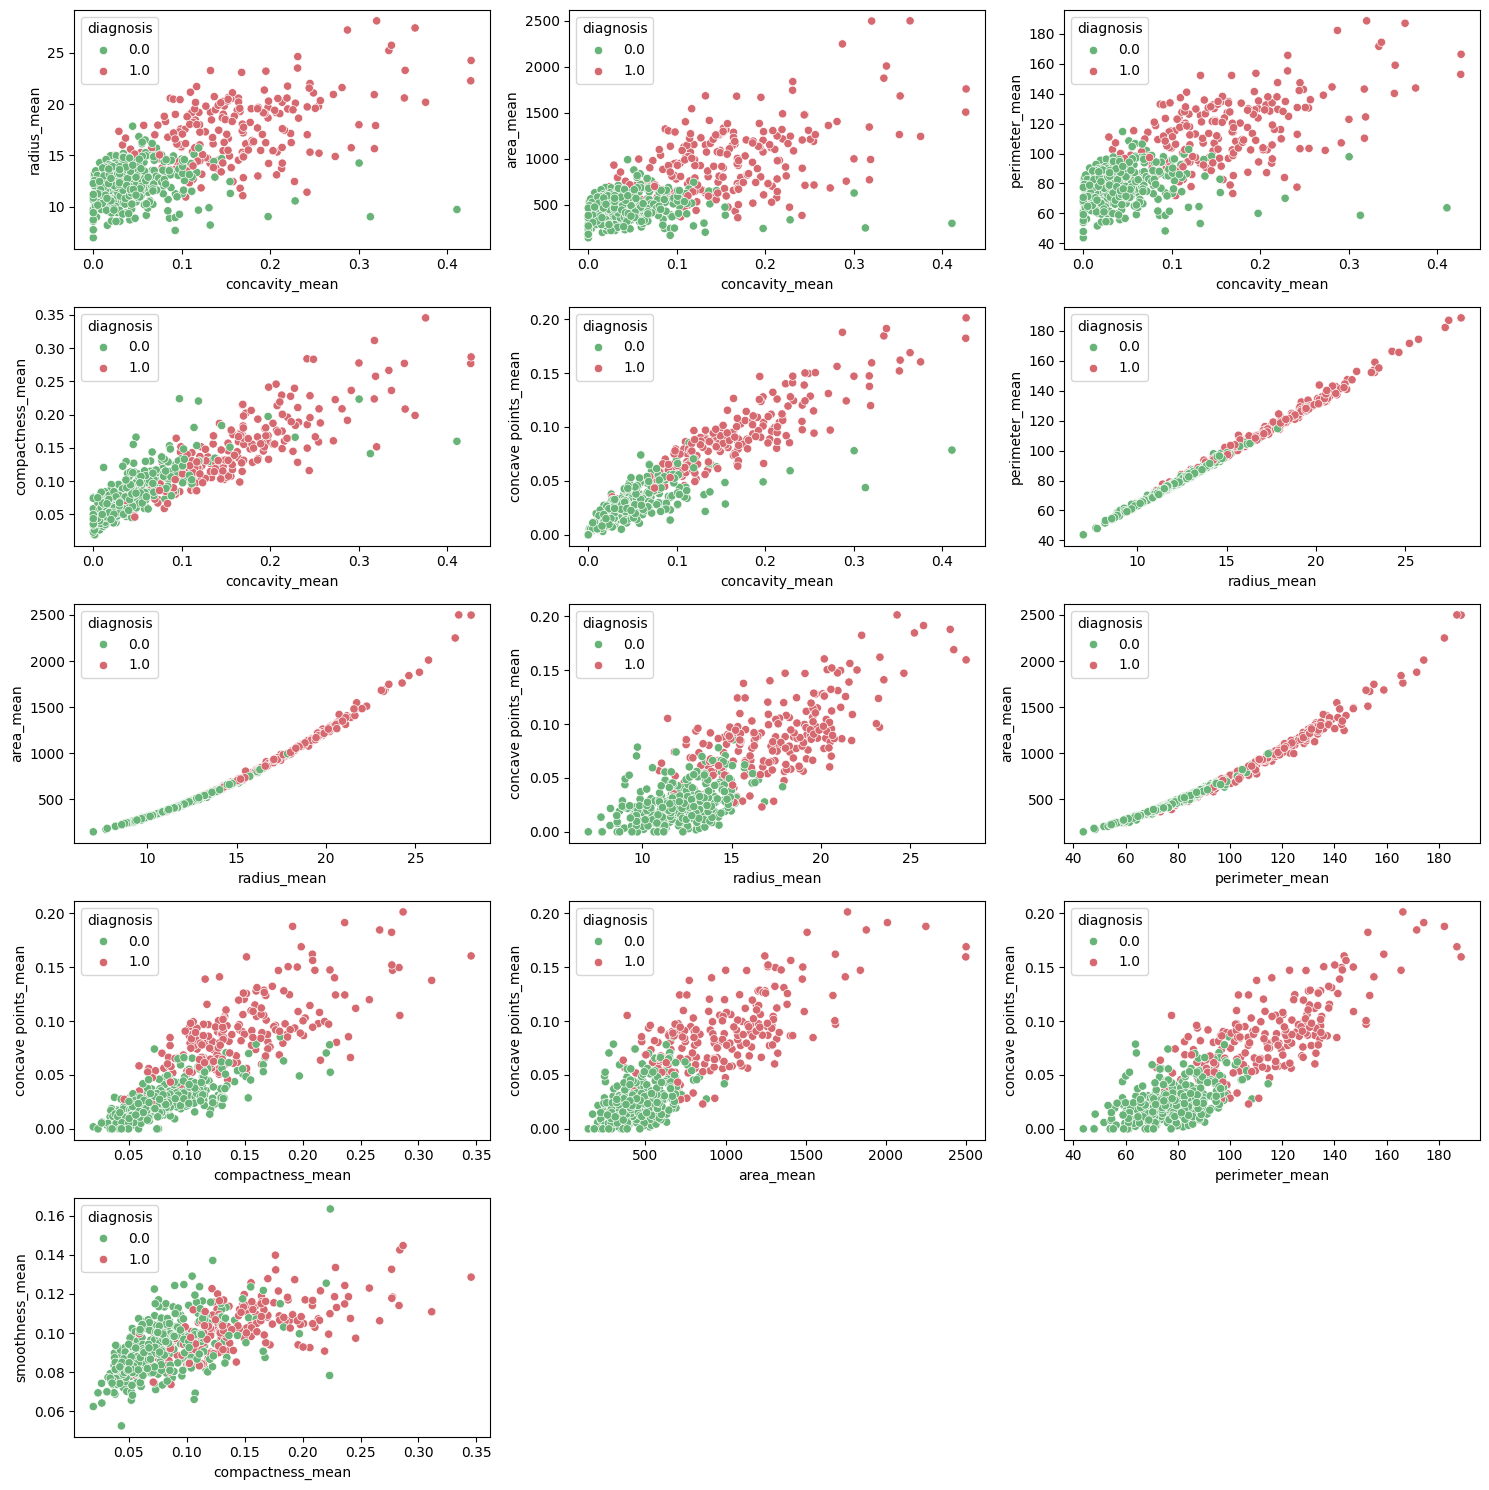

In [16]:
plt.figure(figsize=[15, 15])

plt.subplot(5, 3, 1)
sns.scatterplot(data=data, 
                x='concavity_mean', y='radius_mean', 
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 2)
sns.scatterplot(data=data, 
                x='concavity_mean', y='area_mean', 
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 3)
sns.scatterplot(data=data,
                x='concavity_mean', y='perimeter_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 4)
sns.scatterplot(data=data, 
                x='concavity_mean',y='compactness_mean', 
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 5)
sns.scatterplot(data=data, 
                x='concavity_mean', y='concave points_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 6)
sns.scatterplot(data=data, 
                x='radius_mean', y='perimeter_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 7)
sns.scatterplot(data=data, 
                x='radius_mean', y='area_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 8)
sns.scatterplot(data=data, 
                x='radius_mean', y='concave points_mean', 
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 9)
sns.scatterplot(data=data, 
                x='perimeter_mean', y='area_mean', 
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 10)
sns.scatterplot(data=data, 
                x='compactness_mean', y='concave points_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 11)
sns.scatterplot(data=data, 
                x='area_mean', y='concave points_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 12)
sns.scatterplot(data=data, x='perimeter_mean', y='concave points_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.subplot(5, 3, 13)
sns.scatterplot(data=data, x='compactness_mean', y='smoothness_mean',
                hue='diagnosis', palette=diagnosis_colors)

plt.legend(loc='upper left', title='diagnosis')
plt.tight_layout()
plt.show()

In [17]:
data['radius_mean'].cov(data.area_mean)

1224.483409346457

In [18]:
data['radius_mean'].cov(data.perimeter_mean)

85.44714165573404

In [19]:
data['perimeter_mean'].cov(data.area_mean)

8435.772345082802

 - Высокая ковариация признаков 'perimeter_mean', 'area_mean', 'radius_mean'.
 - Остальные признаки показывают линейную зависимость.

In [20]:
data.drop(['perimeter_mean', 'area_mean',
           'perimeter_worst', 'area_worst',
           'perimeter_se', 'area_se'],
           axis=1, inplace=True)

#### Boxplots

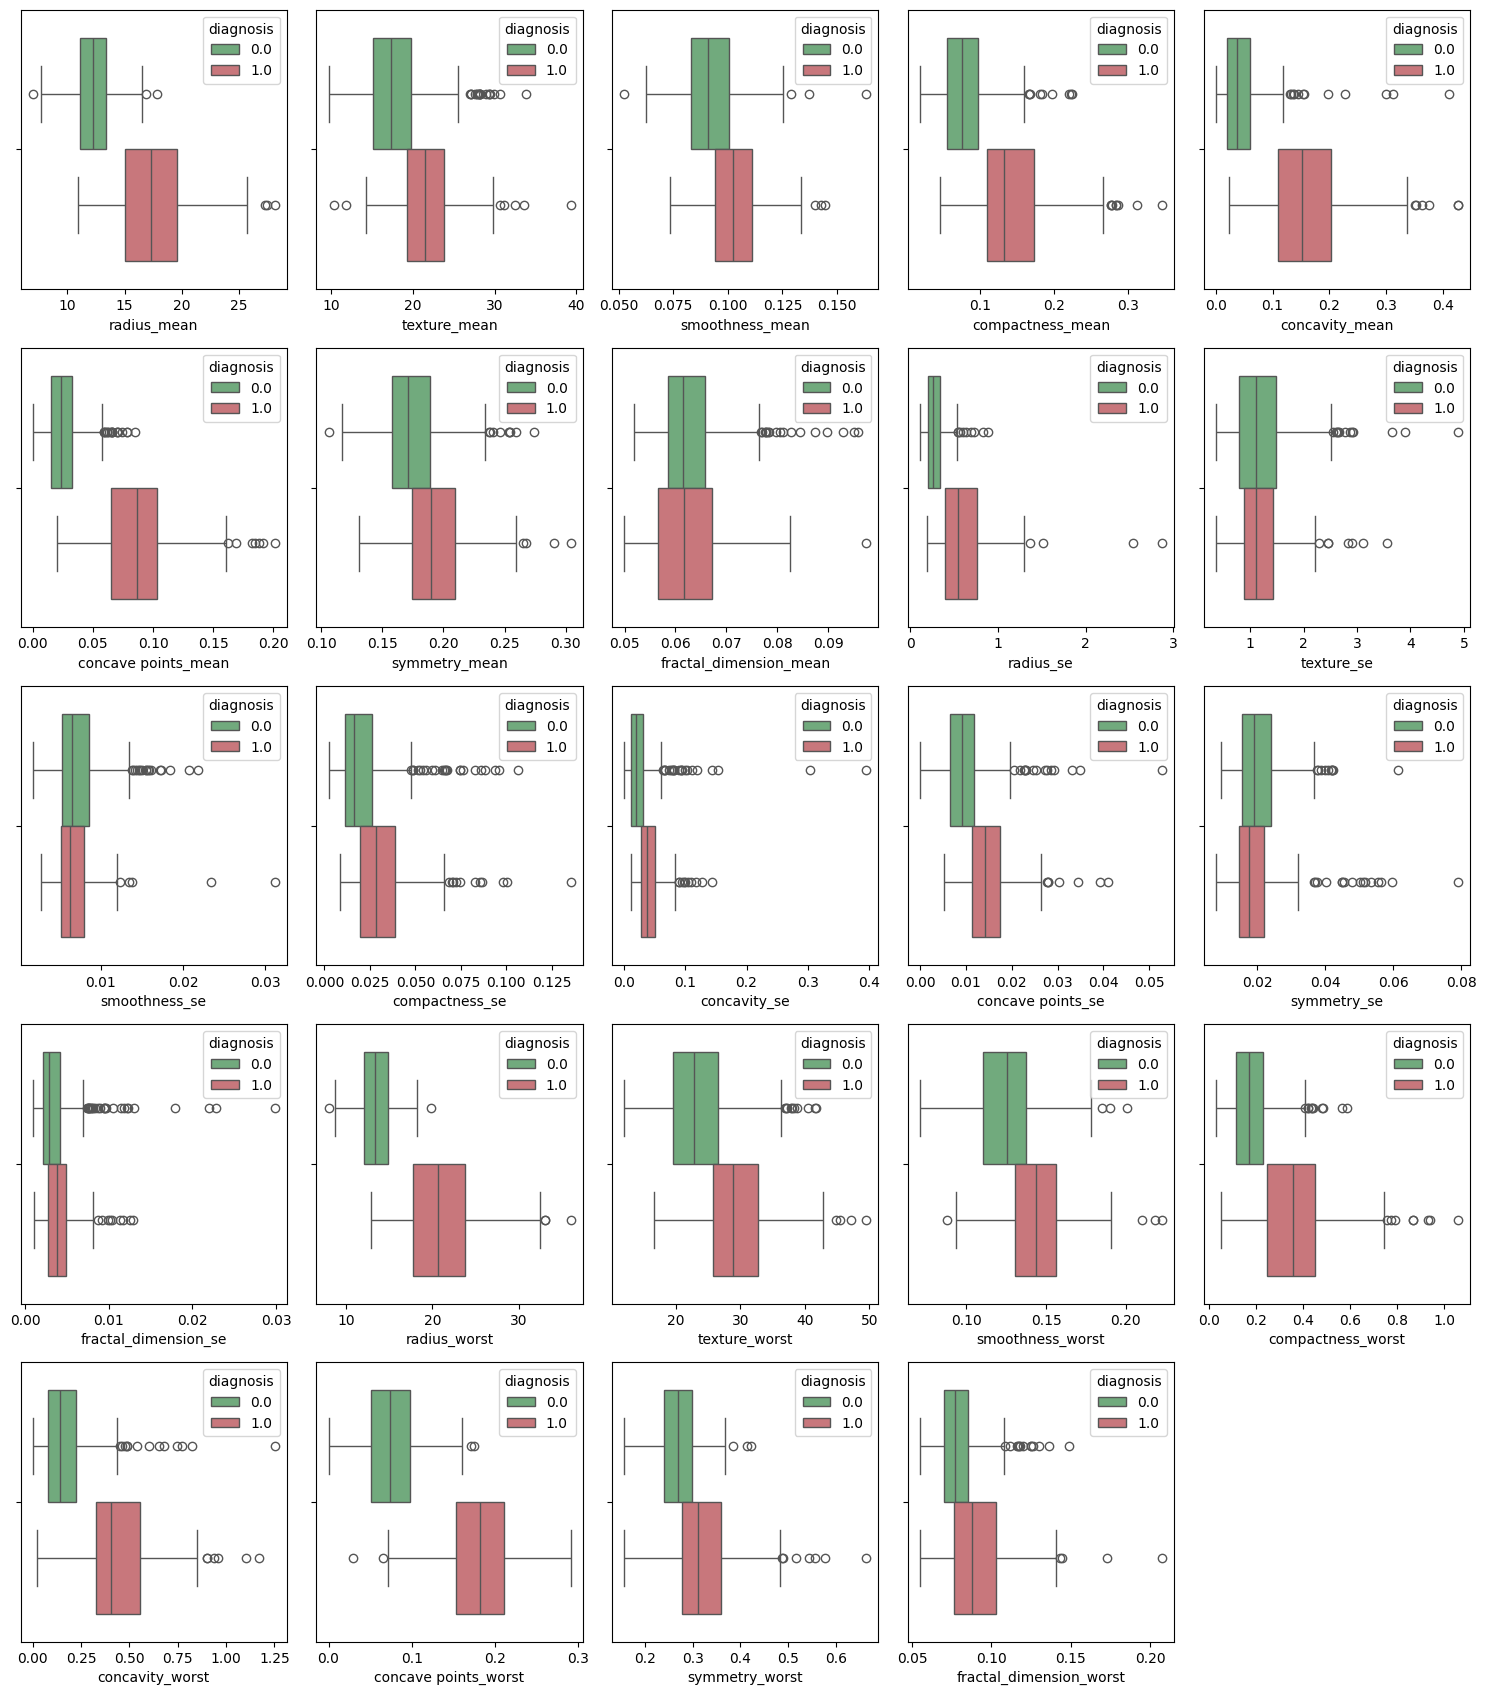

In [21]:
plt.figure(figsize=[15,20])

i = 0

for col in data.columns[1:]:
    plt.subplot(6, 5, i+1)
    sns.boxplot(data=data, x=col, hue='diagnosis', palette=diagnosis_colors,)
    plt.legend(loc='upper right', title='diagnosis')
    i = i + 1

plt.tight_layout()
plt.show()

1. Досточное количество выбросов.
2. Ряд признаков с '_se' наименее информативны.
3. Ширина межквартильного размаха различиается в зависимости от диагноза в следующих признаках:
    - concavity
    - fractal_dimension
    - radius
    - compactness
<br>Значения вышеуказанных признаков у доброкачественных новообразований более однородны.

4. Средние значения следующих признаков у злокачественных опухолей больше, чем у доброкачественных:
    - concavity
    - concave points
    - texture
    - smoothness
    - radius
    - compactness


## Models

In [22]:
def report(pred, actual):
    accuracy = round(accuracy_score(pred, actual), 4)
    precision = round(precision_score(pred, actual), 4)
    recall = round(recall_score(pred, actual), 4)
    f1 = round(f1_score(pred, actual), 4)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nf1_score: {f1}')

In [23]:
k = data.copy()

### kNN

In [24]:
X = k.drop(['diagnosis'], axis=1)
y = k['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 24), (171, 24), (398,), (171,))

#### Из коробки

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_train_knn = knn.predict(X_train)
y_test_knn = knn.predict(X_test)

print("Train quality:")
report(knn.predict(X_train), y_train)
print("\nTest quality:")
report(knn.predict(X_test), y_test)

Train quality:
Accuracy: 0.9724
Precision: 0.9262
Recall: 1.0
f1_score: 0.9617

Test quality:
Accuracy: 0.9649
Precision: 0.9524
Recall: 0.9524
f1_score: 0.9524


In [26]:
def auc_curve(model):
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]

    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)

    auc_train = round(roc_auc_score(y_train, y_pred_proba_train), 4)
    auc_test = round(roc_auc_score(y_test, y_pred_proba_test), 4)

    plt.plot (fpr_train, tpr_train, label=(f'AUC train = {auc_train}'))
    plt.plot (fpr_test, tpr_test, label=(f'AUC test = {auc_test}'))
    plt.ylabel('True positive')
    plt.xlabel('False positive')

    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

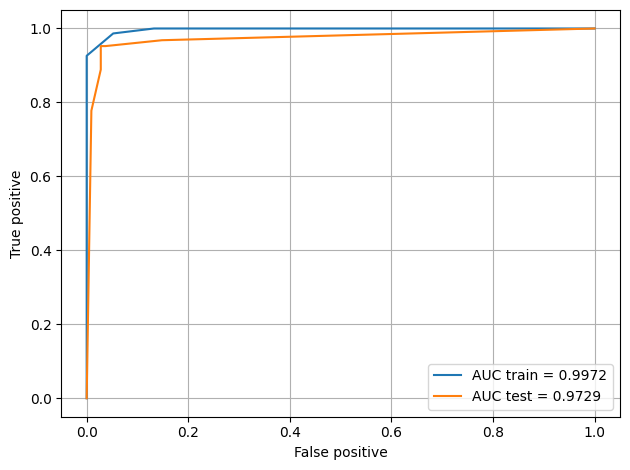

In [27]:
auc_curve(knn)

#### Manual tuning

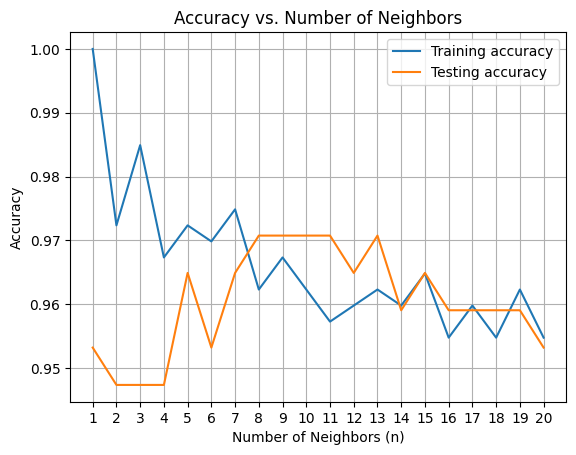

In [28]:
train_accuracy = []
test_accuracy = []

neighbours = range(1, 21)

for n in neighbours:

    knn = KNeighborsClassifier(n_neighbors=n)
    
    knn.fit(X_train, y_train)
       
    y_train_knn = knn.predict(X_train)
    y_test_knn = knn.predict(X_test)
       
        
    train_accuracy.append(accuracy_score(y_train, y_train_knn))
    test_accuracy.append(accuracy_score(y_test, y_test_knn))


plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.plot(neighbours, test_accuracy, label='Testing accuracy')
plt.xlabel('Number of Neighbors (n)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.legend()
plt.xticks(range(1, 21))
plt.grid(visible=True)
plt.show()

In [29]:
knn_m = KNeighborsClassifier(n_neighbors=7)
knn_m.fit(X_train, y_train)

y_train_knn_m = knn_m.predict(X_train)
y_test_knn_m = knn_m.predict(X_test)

print("Train quality:")
report(knn_m.predict(X_train), y_train)
print("\nTest quality:")
report(knn_m.predict(X_test), y_test)

Train quality:
Accuracy: 0.9749
Precision: 0.9329
Recall: 1.0
f1_score: 0.9653

Test quality:
Accuracy: 0.9649
Precision: 0.9524
Recall: 0.9524
f1_score: 0.9524


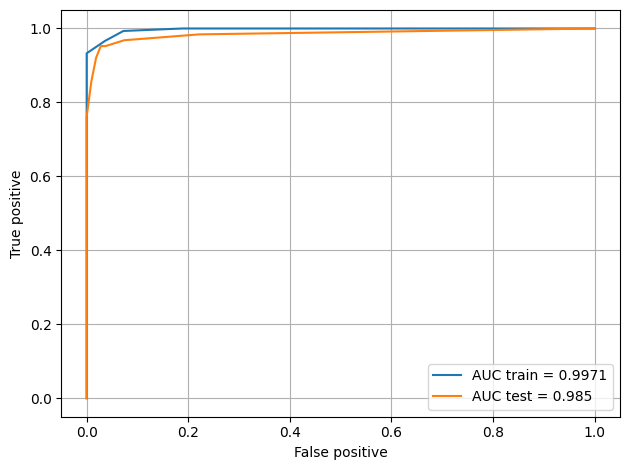

In [30]:
auc_curve(knn_m)

#### GridSearchCV

In [31]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
              'weights': ['uniform', 'distance', None],
              'p': [1, 2, 3]}

gs_knn = GridSearchCV(knn,                 # Classifier object to optimize
                      parameters,          # Grid of the hyperparameters
                      scoring='accuracy',  # Claasification quality metric to optimize
                      cv=5)                # Number of folds in KFolds cross-validation (CV)


gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}

In [32]:
y_gs_train_knn = gs_knn.predict(X_train)
y_gs_test_knn = gs_knn.predict(X_test)

print("Train quality:")
report(gs_knn.predict(X_train), y_train)
print("\nTest quality:")
report(gs_knn.predict(X_test), y_test)

Train quality:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
f1_score: 1.0

Test quality:
Accuracy: 0.9591
Precision: 0.9365
Recall: 0.9516
f1_score: 0.944


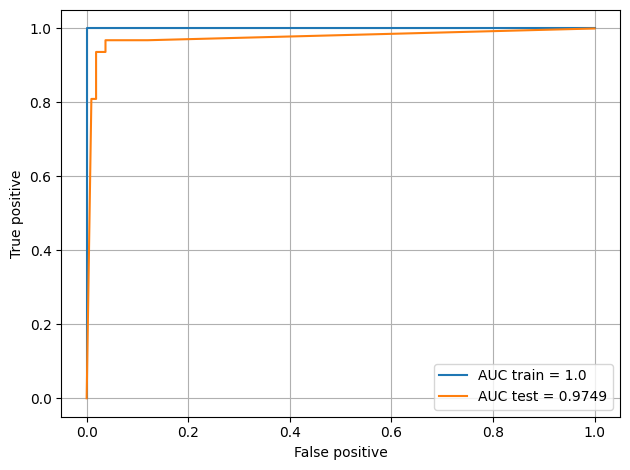

In [33]:
auc_curve(gs_knn)

Выглядит все равно как-то переобученно. Хотелось бы сделать график решений, но тут много признаков, что стало проблемой. Попыталась изменить размерность с помощью PCA, но картинка получилась очень странной.

**Как еще можно отобразить график качества модели, чтобы можно быть визуально оценить ее переобученность?**

### Logistic Regression

In [34]:
l = data.copy()

In [35]:
l.drop(['compactness_worst', 'concave points_worst', 'radius_worst', 'concavity_mean'], axis=1, inplace=True)

In [36]:
X = l.drop(['diagnosis'], axis=1)
y = l['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 20), (171, 20), (398,), (171,))

#### Из коробки

In [37]:
log = LogisticRegression(random_state=42)
log.fit(X_train, y_train)

y_train_log = log.predict(X_train)
y_test_log = log.predict(X_test)

print("Train quality:")
report(log.predict(X_train), y_train)
print("\nTest quality:")
report(log.predict(X_test), y_test)

Train quality:
Accuracy: 0.9874
Precision: 0.9732
Recall: 0.9932
f1_score: 0.9831

Test quality:
Accuracy: 0.9766
Precision: 0.9841
Recall: 0.9538
f1_score: 0.9688


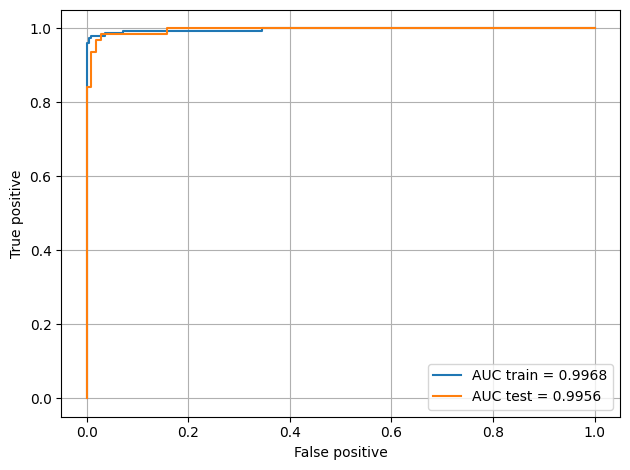

In [38]:
auc_curve(log)

#### GridSearchCV

In [39]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet', None],
              'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0],
              'random_state': [42]}

gs_log = GridSearchCV(log,                 # Classifier object to optimize
                      parameters,          # Grid of the hyperparameters
                      scoring='accuracy',  # Claasification quality metric to optimize
                      cv=5)                # Number of folds in KFolds cross-validation (CV)


gs_log.fit(X_train, y_train)
gs_log.best_params_

{'C': 1.0, 'penalty': 'l2', 'random_state': 42}

In [40]:
y_gs_train_log = gs_log.predict(X_train)
y_gs_test_log = gs_log.predict(X_test)

print("Train quality:")
report(gs_log.predict(X_train), y_train)
print("\nTest quality:")
report(gs_log.predict(X_test), y_test)

Train quality:
Accuracy: 0.9874
Precision: 0.9732
Recall: 0.9932
f1_score: 0.9831

Test quality:
Accuracy: 0.9766
Precision: 0.9841
Recall: 0.9538
f1_score: 0.9688


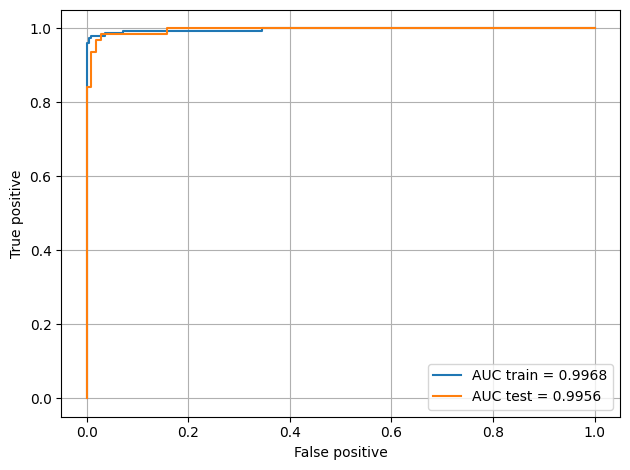

In [41]:
auc_curve(gs_log)

GridSearch решил, что ничего на свете нет лучше коробочной версии с дефолтными значениями параметров.

#### Feature Importance

<Axes: >

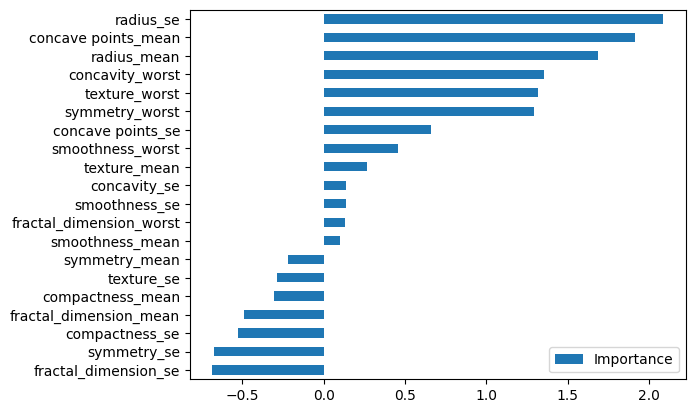

In [42]:
feature = l.drop(['diagnosis'], axis=1).columns
importance = log.coef_[0]
f_i = pd.DataFrame(index=feature,
                   data={'Importance': importance})
f_i.sort_values(['Importance'], inplace=True)

f_i.plot.barh()